In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import random

from shapely.geometry import Polygon

import matplotlib.pyplot as plt

In [2]:
# Load the point shapefile
points = gpd.read_file('data/BuildingsCentroids_OSM_UTK.shp')

In [3]:
points = points[0:10]

In [4]:
points

,name,w,geometry
0,Neyland Stadium,3,POINT (-83.92569 35.95466)
1,Humanities and Social Sciences,3,POINT (-83.92902 35.95367)
2,McClung Tower,6,POINT (-83.92897 35.95408)
3,University Printing & Mail,4,POINT (-83.92825 35.94675)
4,UT Warehouse,3,POINT (-83.92908 35.94662)
5,NaN,2,POINT (-83.93060 35.94640)
6,UT Warehouse,3,POINT (-83.92970 35.94656)
7,NaN,1,POINT (-83.92942 35.94971)
8,Alumni Memorial Building,3,POINT (-83.92631 35.95601)
9,Ayres Hall,3,POINT (-83.92592 35.95744)


In [2]:
# point pattern generator
def PointsGen(Xls, Yls):
    IDls = []
    for i in range(0, len(Xls)):
        IDls.append(i + 1)
    df_dict = {'ID': IDls, 'XCoord': Xls, 'YCoord': Yls}
    df = pd.DataFrame(df_dict)
    df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(Xls, Yls))
    return df

In [3]:
# generate demand weights
def weight_gen(points):
    num = len(points)
    points['Weight'] = np.random.poisson(4, num)
    #points['Weight'] = 9 * (points['XCoord'] + points['YCoord']) + 1 + 0.01 * (np.random.normal(0, 1, num))
    #points['Weight'] = 5 * ((points['XCoord'] + points['YCoord']) ** 2) + 1 + 0.01 * (np.random.normal(0, 1, num))
    #points['Weight'] = 5 * (np.sin(points['XCoord'] * np.pi) + 2 * np.sin(points['YCoord'] * np.pi)) + 1 + 0.01 * (np.random.normal(0, 1, num))
    return points

In [4]:
# generate boundary
x_coords = [0, 1, 1, 0]
y_coords = [0, 0, 1, 1]
polygon_geom = Polygon(zip(x_coords, y_coords))
extent = gpd.GeoDataFrame(index = [0], geometry = [polygon_geom])
del x_coords, y_coords, polygon_geom

In [ ]:
# generate a point set
points = PointsGen(np.random.beta(1, 1, 50), np.random.beta(1, 1, 50))
points = weight_gen(points)

In [5]:
# Set the number of facilities (p)
p = 2

# Define parameters for simulated annealing
temperature = 30
max_iter = 10
cooling_rate = 0.70
tol_val = 10

In [6]:
# Generate an initial solution randomly
initial_solution = random.sample(range(len(points)), p)

In [7]:
def calculate_total_cost(points, weight, solution):
    total_cost = 0
    for point in points.geometry:
        distances = point.distance(points.geometry[best_solution])
        cost_ls = []
        for idx in best_solution:
            distance = distances[idx] 
            w = points[weight][idx]
        cost_ls.append(distance * w)
        total_cost += min(cost_ls)
    return total_cost

In [8]:
# Calculate the total cost of the initial solution
current_solution = initial_solution
best_solution = initial_solution
best_cost = calculate_total_cost(points, 'w', best_solution)
best_cost

0.158917932736568

In [9]:
# Simulated annealing algorithm
optsol_ls = []
sim_ls = []
optsol_ls.append(best_cost)
sim_ls.append(best_cost)
count = 0
while temperature > tol_val:
    while count < max_iter:
        # Generate a new solution by swapping two facilities
        new_solution = current_solution.copy()
        idx1 = random.choice(range(p))
        idx2 = random.choice([idx for idx in range(len(points)) if idx not in current_solution])
        new_solution[idx1] = idx2
        count += 1

        # Calculate the cost of the new solution
        new_cost = calculate_total_cost(points, 'w', new_solution)
        sim_ls.append(new_cost)

        if new_cost < best_cost:
            current_solution = new_solution
            best_solution = new_solution
            best_cost = new_cost
            optsol_ls.append(best_cost)
            count = 0
        
        elif random.random() < np.exp((best_cost - new_cost) / temperature):
            current_solution = new_solution
            best_solution = new_solution
            best_cost = new_cost
            optsol_ls.append(best_cost)
            count = 0
            
    temperature *= cooling_rate
    count = 0

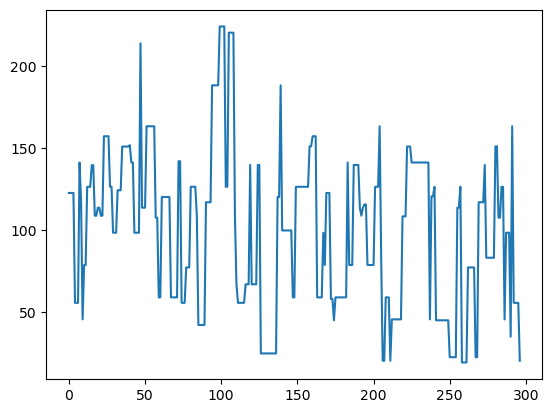

In [76]:
plt.plot(optsol_ls)

In [78]:
points[0:2]

,ID,XCoord,YCoord,geometry,Weight
0,1,0.696584,0.565111,POINT (0.69658 0.56511),3
1,2,0.965807,0.184291,POINT (0.96581 0.18429),6


In [79]:
facility_locations = points.iloc[best_solution].geometry

(-0.05, 1.05)

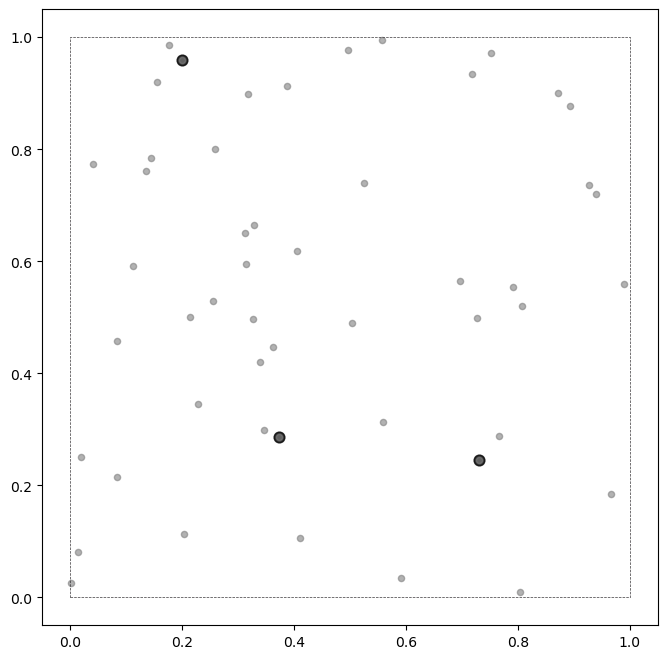

In [87]:
# display the result from CVXPY
plt.rcParams['figure.figsize'] = [8, 8]
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
extent.boundary.plot(ax = ax, edgecolor = '#393739', linestyle = '--', linewidth = 0.5)
gpd.GeoDataFrame(geometry = facility_locations).plot(ax = ax, color = 'black', alpha = 0.8, markersize = 60)
points.plot(ax = ax, color = 'grey', alpha = 0.6, markersize = 20)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])